<a href="https://colab.research.google.com/github/LuuZwide/Preprocessing-/blob/main/Dimension_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import yfinance as yf
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Functions/Preprocessing/Precossing_Functions_for_stock_chpters_1.ipynb" .
%run Precossing_Functions_for_stock_chpters_1.ipynb

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import PolynomialFeatures

ticker = yf.Ticker("AAPL")
apple_data = ticker.history(period="Max")
apple_data = apple_data.drop(['Dividends','Stock Splits'] , axis = 1)
apple_data.reset_index(drop = False, inplace = True)

ticker = yf.Ticker("IBM")
ibm_data = ticker.history(period="Max")
ibm_data = ibm_data.drop(['Dividends','Stock Splits'] , axis = 1)
ibm_data.reset_index(drop = False, inplace = True)

ticker = yf.Ticker("GE")
ge_data = ticker.history(period="Max")
ge_data = ge_data.drop(['Dividends','Stock Splits'] , axis = 1)
ge_data.reset_index(drop = False, inplace = True)

ticker = yf.Ticker("amzn")
amzn_data = ticker.history(period="Max")
amzn_data = amzn_data.drop(['Dividends','Stock Splits'] , axis = 1)
amzn_data.reset_index(drop = False, inplace = True)

ticker = yf.Ticker("GOOGL")
google_data = ticker.history(period="Max")
google_data = google_data.drop(['Dividends','Stock Splits'] , axis = 1)
google_data.reset_index(drop = False, inplace = True)

stock_pd = pd.concat([apple_data])
stock_pd = stock_pd.reset_index(drop = True)
stock_pd.head()
stock_pd.describe()

prices = stock_pd['Close']
len_of_data = len(prices)
window_size = 5
stock_dataset = Combine_dataframes(stock_pd ,prices, window_size,len_of_data, fast = 12, slow = 26)


val_data = apple_data
val_prices = val_data['Close']
len_of_data = len(val_prices)
window_size = 5
val_dataset = Combine_dataframes(val_data ,val_prices, window_size,len_of_data, fast = 12, slow = 26)

attribute = 'moving_avg'
split_cat = 'avg_cat'
dividing_value = 5
max_value = 10
set_max_value = 10
stock_dataframe = cat_for_split(stock_dataset,attribute, split_cat, dividing_value, max_value, set_max_value)

val_dataframe = cat_for_split(val_dataset,attribute, split_cat, dividing_value, max_value, set_max_value)

def CreateNextCloseCat(stock_dataset):
  Y_values = []
  close_values = stock_dataset['Close']
  len_of_data = len(stock_dataset)
  for i in range(len_of_data - 1):
    if(close_values[i + 1] > close_values[i]):
      Y_values.append(True)
    else:
      Y_values.append(False)

  Y_values.append(False)
  return np.array(Y_values)

Y_train = CreateNextCloseCat(stock_dataframe)
num_True = np.count_nonzero(Y_train)
num_False = np.count_nonzero(~Y_train)
print('Number of Trues: ',num_True)
print('Number of Falses: ',num_False)
print('Shape of Y: ', Y_train.shape)

X = stock_dataframe.drop('next_close', axis = 1)
y = Y_train

print('train y: ', y.shape)
print('train x : ',X.shape )

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
attribs = list(x_train.columns)
#attribs = list(['Open', 'High', 'Low', 'Close', 'moving_avg', 'exm_avg'])
print(len(x_train))
print(len(x_test))

data_pipeline = Pipeline(
    (
        ('ConvertDataFrame',DataFrameSelector(attribs)),
        ('Scaler', StandardScaler())
    )
)

x_train_prepared = data_pipeline.fit_transform(x_train)
print('x_train shape: ',x_train_prepared.shape)
print('y_train shape: ',y_train.shape)

Mounted at /content/drive
Number of Trues:  5302
Number of Falses:  5368
Shape of Y:  (10670,)
train y:  (10670,)
train x :  (10670, 13)
8536
2134
x_train shape:  (8536, 13)
y_train shape:  (8536,)


In [ ]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# PCA

In [ ]:
pca  = PCA(n_components= 2)
X2D = pca.fit_transform(x_train_prepared)

print(X2D.shape)
print(pca.explained_variance_ratio_)
# that means 56% of the data's variance lies in the first axis and 17% lies in the second axis
# and the other percents are in the other axis...


(8536, 2)
[0.56405648 0.17770312]


# Choosing the right number of Dimensions

In [ ]:
# to find the dimensions required for 95% variance of data

pca = PCA()
pca.fit(x_train_prepared)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

# now we set n_components to d
# Or
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(x_train_prepared)
print(X_reduced.shape)

5
(8536, 5)


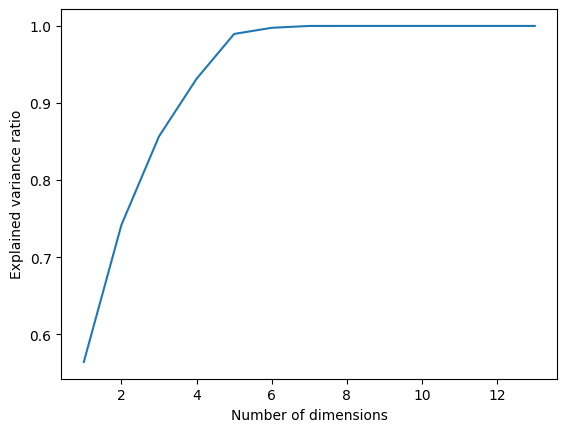

In [ ]:
n_dims = len(cumsum)
plt.plot(range(1, n_dims+1), cumsum)
plt.xlabel('Number of dimensions')
plt.ylabel('Explained variance ratio')
plt.show()

# kernel PCA

In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma  = 0.04)
x_reduced = rbf_pca.fit_transform(x_train_prepared)

# Selecting a Kernel and Tuning Hyperparameters

In [ ]:
clf = Pipeline([
    ('kpca', KernelPCA(n_components = 5)),
     ('elastic_reg',ElasticNet(alpha = 1.4, l1_ratio = 0.01))
])

param_grid = [{
    'kpca__gamma':np.linspace(0.03, 0.05, 10),
    'kpca__kernel':['rbf','sigmoid']
}]


grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(x_train_prepared, y_train)


predictions = grid_search.best_estimator_.predict(x_train_prepared)
elastic_mse = mean_squared_error(y_train, predictions)
print('mse: ', elastic_mse)
print('rmse: ',  np.sqrt(elastic_mse))
print('best params: ', grid_search.best_params_)

mse:  0.24988383726149307
rmse:  0.4998838237645754


LLE (Local Linear Embedding)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)


best params:  {'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}
